💬 Chat Benchmark Analysis

This notebook analyzes the end-to-end performance of our chat function based on the data collected in `chat_benchmark_results.csv`.


In [1]:
# ## 1. Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

try:
    df = pd.read_csv('chat_benchmark_results.csv')
    print("✅ Chat data loaded successfully!")
    print(f"Total records found: {len(df)}")
except FileNotFoundError:
    print("❌ Error: chat_benchmark_results.csv not found.")
    df = pd.DataFrame()

if not df.empty:
    display(df.head())

✅ Chat data loaded successfully!
Total records found: 100


,timestamp,model_ids,user_prompt,e2e_time_ms,error,chat_id,response_title,assistant_completion,generation_time_ms,confidence
0,2025-09-22T22:26:11.629984,[3],Please explain the different components of the...,8808.6864,NaN,60ca99b0-e605-4353-b786-6e00c99f0142,Remove first and last occurrence of a given ch...,\n\nThe solution involves creating a function ...,8765,0.0
1,2025-09-22T22:26:20.424422,[3],Please explain the different components of the...,8794.2474,NaN,008a15b0-11b3-47ce-96c6-d46d13bf312d,Sorting Matrix by Row Sums,"\n\nTo solve this problem, we need to follow t...",8765,0.0
2,2025-09-22T22:26:29.212510,[3],Please explain the different components of the...,8787.2164,NaN,6d748fdd-d630-427b-9f16-92989fcef0bf,Components of Solution,\n\nThe solution involves several steps:\n\n1....,8761,0.0
3,2025-09-22T22:26:38.060337,[3],Please explain the different components of the...,8848.0844,NaN,1024d15e-2b04-41d1-902f-e5d8ff648f11,Components of Volume Calculation Function,\n\nThe volume V of a triangular prism can be ...,8762,0.0
4,2025-09-22T22:26:44.096993,[3],Please explain the different components of the...,6035.6339,NaN,cf49956b-3b61-4bda-b2e0-45c03d9f4068,String splitting by lowercase letters,\n\nThe solution involves creating a function ...,6008,0.0


In [2]:
# ## 2. Data Cleaning and Feature Engineering
if not df.empty:
    initial_rows = len(df)
    df_success = df[df['error'].isnull()].copy()
    print(f"Filtered out {initial_rows - len(df_success)} failed requests. Analyzing {len(df_success)} successful requests.")

    # --- Feature Engineering ---
    df_success['prompt_length'] = df_success['user_prompt'].str.len()
    df_success['completion_length'] = df_success['assistant_completion'].str.len()
    df_success['num_completion_tokens'] = df_success['assistant_completion'].str.split().str.len()

    # --- Calculate Performance Metrics ---
    df_success['tokens_per_second'] = (df_success['num_completion_tokens'] / df_success['generation_time_ms']) * 1000
    df_success.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_success.dropna(subset=['tokens_per_second', 'completion_length'], inplace=True)
    
    print("\n✅ Feature engineering complete.")
    display(df_success[['e2e_time_ms', 'prompt_length', 'completion_length', 'tokens_per_second']].head())


Filtered out 0 failed requests. Analyzing 100 successful requests.

✅ Feature engineering complete.


,e2e_time_ms,prompt_length,completion_length,tokens_per_second
0,8808.6864,180,1156,19.851683
1,8794.2474,175,897,15.059897
2,8787.2164,147,1035,16.550622
3,8848.0844,148,989,18.717188
4,6035.6339,139,661,16.977364


--- 🔬 End-to-End (E2E) Latency for Chat ---
Mean:   8369.78 ms
Median (P50): 8788.58 ms
P90:    8794.63 ms
P95:    8801.11 ms
Token Mean:   150.80 tokens


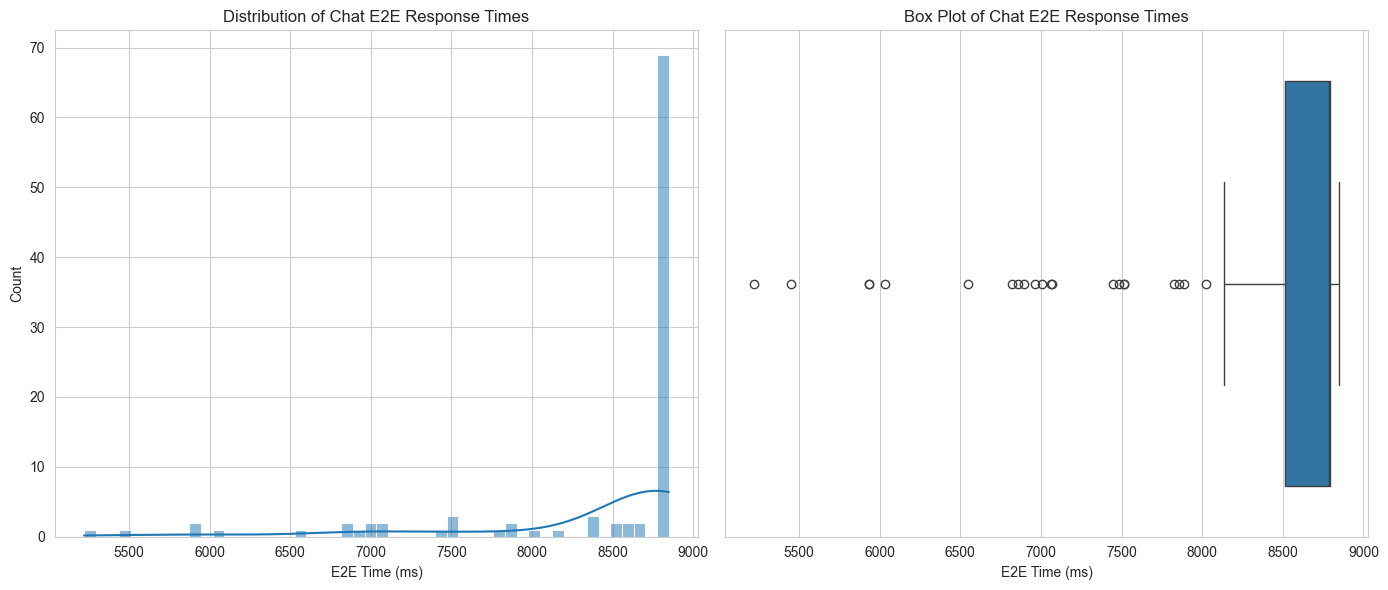

In [5]:
# ## 3. Overall Performance Summary 📜
if not df_success.empty:
    e2e_stats = df_success['e2e_time_ms'].describe(percentiles=[.5, .90, .95, .99])
    
    print("--- 🔬 End-to-End (E2E) Latency for Chat ---")
    print(f"Mean:   {e2e_stats['mean']:.2f} ms")
    print(f"Median (P50): {e2e_stats['50%']:.2f} ms")
    print(f"P90:    {e2e_stats['90%']:.2f} ms")
    print(f"P95:    {e2e_stats['95%']:.2f} ms")



    token_stats = df_success['num_completion_tokens'].describe(percentiles=[.5, .90, .95, .99])
    print(f"Token Mean:   {token_stats['mean']:.2f} tokens")
    
    # --- Visualization: Latency Distribution ---
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_success['e2e_time_ms'], kde=True, bins=50)
    plt.title('Distribution of Chat E2E Response Times')
    plt.xlabel('E2E Time (ms)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_success['e2e_time_ms'])
    plt.title('Box Plot of Chat E2E Response Times')
    plt.xlabel('E2E Time (ms)')
    
    plt.tight_layout()
    plt.show()

--- ⚡ Model Generation Throughput for Chat ---
Mean:   18.08 tokens/sec
Median: 18.38 tokens/sec


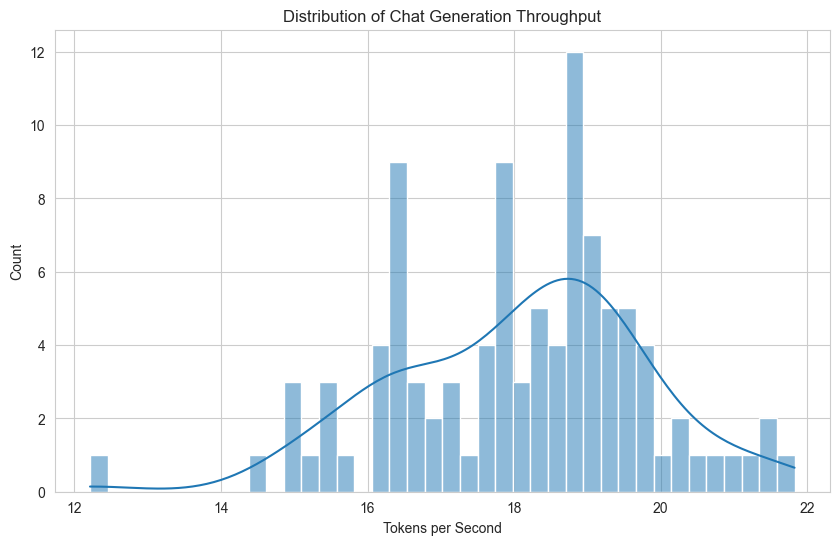

In [6]:
# ## 4. Throughput Analysis (Tokens per Second) 🚀
if not df_success.empty:
    throughput_stats = df_success['tokens_per_second'].describe(percentiles=[.5, .90, .95])

    print("--- ⚡ Model Generation Throughput for Chat ---")
    print(f"Mean:   {throughput_stats['mean']:.2f} tokens/sec")
    print(f"Median: {throughput_stats['50%']:.2f} tokens/sec")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df_success['tokens_per_second'], kde=True, bins=40)
    plt.title('Distribution of Chat Generation Throughput')
    plt.xlabel('Tokens per Second')
    plt.show()

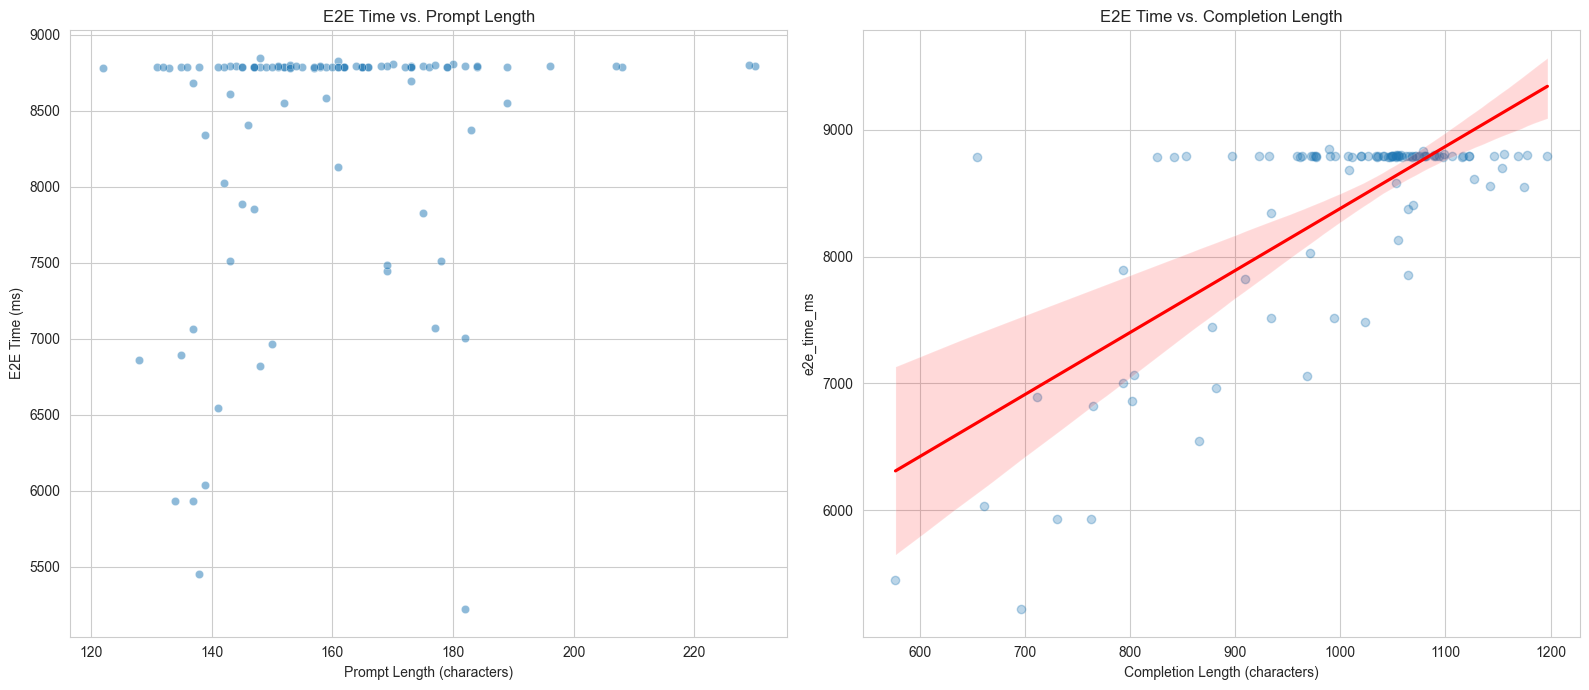

As with completions, we see a strong correlation between the length of the assistant's response and the total time taken.


In [7]:
# ## 5. Performance vs. Input/Output Length 📏
if not df_success.empty:
    plt.figure(figsize=(16, 7))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_success, x='prompt_length', y='e2e_time_ms', alpha=0.5)
    plt.title('E2E Time vs. Prompt Length')
    plt.xlabel('Prompt Length (characters)')
    plt.ylabel('E2E Time (ms)')

    plt.subplot(1, 2, 2)
    sns.regplot(data=df_success, x='completion_length', y='e2e_time_ms', 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('E2E Time vs. Completion Length')
    plt.xlabel('Completion Length (characters)')
    
    plt.tight_layout()
    plt.show()
    print("As with completions, we see a strong correlation between the length of the assistant's response and the total time taken.")


In [8]:
# ## 6. Identifying the Slowest Chat Requests 🐢
if not df_success.empty:
    slowest_requests = df_success.sort_values(by='e2e_time_ms', ascending=False).head(10)
    print("--- Top 10 Slowest Chat Requests ---")
    # Using style for better text wrapping in the notebook
    display(slowest_requests[['user_prompt', 'assistant_completion', 'e2e_time_ms', 'completion_length']].style.set_properties(**{'white-space': 'pre-wrap'}))


--- Top 10 Slowest Chat Requests ---


,user_prompt,assistant_completion,e2e_time_ms,completion_length
3,Please explain the different components of the solution for the following problem: Write a python function to find the volume of a triangular prism.,"The volume V of a triangular prism can be calculated using the formula: V = (Base Area * Height) / 2 Here are the steps to create a Python function that calculates this: 1. **Define the Function**: Create a function named `calculate_volume` that takes three parameters - base_area, height, and side_length. 2. **Calculate Base Area**: Use Heron's formula to calculate the area of the triangle with sides given by `side_length`. Heron's Formula: A = sqrt(s * (s - a) * (s - b) * (s - c)) Where s is the semi-perimeter of the triangle, and a, b, c are the lengths of the sides. 3. **Calculate Volume**: Multiply the base area by the height and divide by 2. 4. **Return the Result**: Return the calculated volume. Here’s an example implementation: ```python import math def calculate_volume(base_area, height): # Calculate the volume using the formula volume = (base_area * height) / 2 return volume # Example usage base_area = 50 # Example base area height",8848.084400,989
13,Please explain the different components of the solution for the following problem: Write a function to convert the given binary number to its decimal equivalent.,"The different components of the solution for converting a binary number to its decimal equivalent include: 1. **Input Handling**: Accepting the binary string from the user or another source. 2. **Validation**: Ensuring that the input is a valid binary number (contains only '0' and '1'). 3. **Conversion Logic**: Implementing the logic to convert each bit of the binary number to its decimal value using positional notation. 4. **Output Generation**: Returning the decimal equivalent. Here is an example implementation in Python: ```python def binary_to_decimal(binary_str): # Input handling binary_str = str(binary_str) # Validation if not all(char in '01' for char in binary_str): raise ValueError(""Invalid binary number"") # Conversion Logic decimal_value = 0 for i, bit in enumerate(reversed(binary_str)): decimal_value += int(bit) * (2 ** i) return decimal_value # Example usage binary_number = ""1101"" print(f""The decimal equivalent of {binary_number} is {binary_to_decimal(binary_number)}"") ``` This function takes a",8830.868400,1079
12,Please explain the different components of the solution for the following problem: Write a python function to find the maximum sum of elements of list in a list of lists.,"To solve this problem, we need to create a Python function that can iterate through each sublist in a list of lists and calculate the sum of its elements. The function should then return the maximum sum found among all the sublists. Here are the main components of the solution: 1. **Iterate Through Sublists**: Loop through each sublist in the given list of lists. 2. **Calculate Sums**: For each sublist, compute the sum of its elements. 3. **Track Maximum Sum**: Keep track of the highest sum encountered during the iteration. 4. **Return Result**: After iterating through all sublists, return the maximum sum. Let's break down these steps with an example implementation: ```python def max_sum_of_sublists(lst): # Initialize the variable to store the maximum sum max_sum = float('-inf') # Iterate over each sublist in the list of lists for sublist in lst: # Calculate the sum of the current sublist current_sum = sum(sublist) # Update the maximum sum if the current sum is greater if current_sum > max_sum: max_sum = current_sum",8811.211300,1099
0,Please explain the different components of the solution for the following problem: Write a python function to remove first and last occurrence of a given character from the string.,"The solution involves creating a function that takes three parameters: the input string, the character to be removed, and an optional parameter indicating whether to remove only the first or 